In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
train = pd.read_csv("/Users/apple/Desktop/projects/predict-nhl-player-salaries/train.csv", encoding = "ISO-8859-1")
test = pd.read_csv("/Users/apple/Desktop/projects/predict-nhl-player-salaries/test.csv", encoding = "ISO-8859-1")
salary_test = pd.read_csv("/Users/apple/Desktop/projects//predict-nhl-player-salaries/test_salaries.csv")
list(test.shape)
from sklearn.ensemble.forest import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import xgboost as xgb
import matplotlib.pyplot as plt
train.head()

/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


,Salary,Born,City,Pr/St,Cntry,Nat,Ht,Wt,DftYr,DftRd,...,PEND,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G
0,925000,97-01-30,Sainte-Marie,QC,CAN,CAN,74,190,2015.0,1.0,...,1.0,0.0,-0.2,-0.2,40.03,1,0.0,175.7,-0.4,-0.38
1,2250000,93-12-21,Ottawa,ON,CAN,CAN,74,207,2012.0,1.0,...,98.0,-0.2,3.4,3.2,2850.59,290,13.3,112.5,14.1,0.18
2,8000000,88-04-16,St. Paul,MN,USA,USA,72,218,2006.0,1.0,...,70.0,3.7,1.3,5.0,2486.75,102,6.6,114.8,36.8,0.57
3,3500000,92-01-07,Ottawa,ON,CAN,CAN,77,220,2010.0,1.0,...,22.0,0.0,0.4,0.5,1074.41,130,17.5,105.1,5.9,0.20
4,1750000,94-03-29,Toronto,ON,CAN,CAN,76,217,2012.0,1.0,...,68.0,-0.1,1.4,1.3,3459.09,425,8.3,99.5,21.8,0.27


In [2]:
train['Nat'].nunique()

16

In [3]:
# calculating age from date of birth
def age(start, end= datetime(2019,10,17)):
    x = ((end - start)/365)
    return x.days

train['Present_age'] = train.apply(lambda x: 
    age(datetime.strptime(x['Born'], '%y-%m-%d')) ,axis=1)

test['Present_age'] = test.apply(lambda x: 
    age(datetime.strptime(x['Born'], '%y-%m-%d')) ,axis=1)


In [4]:
#dropping city,state,country as nationality is already there
#dropping name 
#dropping date of birth as age column is added
drop = ['City', 'Pr/St', 'Cntry', 'Last Name', 'First Name', 'Team', 'Born']
train.drop(drop, axis = 1, inplace = True)
test.drop(drop, axis = 1, inplace = True)

In [5]:
# making dataframes for cateogerical columns and numerical columns
cat1_train = train.select_dtypes('object')
num1_train = train.select_dtypes(exclude=['object'])
cat1_test = test.select_dtypes('object')
num1_test = test.select_dtypes(exclude=['object'])

In [6]:
cat1_train.head()

,Nat,Hand,Position
0,CAN,L,D
1,CAN,R,D
2,USA,R,RW
3,CAN,R,D
4,CAN,R,RW


In [7]:
# filling in blanks with NA and replacing in them with median
num1_train.fillna
num1_test.fillna
num_train = num1_train.fillna(num1_train.median()) 
num_test = num1_test.fillna(num1_test.median())

In [8]:
a = cat1_train.replace(['CAN', 'USA'], 'N' )
cata_train = a.replace(['SWE', 'CZE', 'CHE', 'FRA', 'DEU', 'SVK', 'RUS',
       'FIN', 'AUT', 'NOR', 'DNK', 'LVA', 'HRV', 'GBR'], 'I')
b = cat1_test.replace(['CAN', 'USA'], 'N' )
catb_test = b.replace(['SWE', 'CZE', 'CHE', 'FRA', 'DEU', 'SVK', 'RUS',
       'FIN', 'AUT', 'NOR', 'DNK', 'LVA', 'HRV', 'GBR','SVN'], 'I')
cata_train.head()

,Nat,Hand,Position
0,N,L,D
1,N,R,D
2,N,R,RW
3,N,R,D
4,N,R,RW


In [9]:
#from sklearn.preprocessing import OneHotEncoder
#ohe = OneHotEncoder(categories='auto')
#feature_arr = ohe.fit_transform(cat_train[['Position','Nat','Hand']]).toarray()
#feature_labels = ohe.categories_
#feature_labels = np.array(feature_labels).ravel()
#features = pd.DataFrame(feature_arr, columns=feature_labels)
#cat_train = cata_train.join(cata_train.Position.str.get_dummies(),cata_train.Nat.str.get_dummies(),cata_train.Hand.str.get_dummies())
cat_split_train = pd.get_dummies(cata_train)
cat_split_test = pd.get_dummies(catb_test)
cat_train = pd.DataFrame.from_dict(cat_split_train) 
cat_test = pd.DataFrame.from_dict(cat_split_test) 

In [10]:
test_clean =  pd.concat([num_test,cat_test], axis = 1)
train_clean =  pd.concat([num_train,cat_train], axis = 1)
#test_clean = pd.concat((num_test,cat_test),axis=1)
#test_clean =  pd.DataFrame.merge(num_test,cat_test, axis=0, ignore_index=True)

In [11]:
#ss = StandardScaler()
#train_ss = ss.fit_transform(train_clean)
#test_ss = ss.fit_transform(test_clean)

In [12]:
#print(train_ss.mean(axis=0))
#print(test_ss.std(axis=0))

In [13]:
labels_train = train_clean['Salary']
features_train = train_clean.drop('Salary', axis = 1)
#labels_train = pd.DataFrame(labels_train)
#features_train = pd.DataFrame(features_train)
features_train.head()

,Ht,Wt,DftYr,DftRd,Ovrl,GP,G,A,A1,A2,...,Position_LW,Position_LW/C,Position_LW/C/RW,Position_LW/RW,Position_LW/RW/C,Position_RW,Position_RW/C,Position_RW/C/LW,Position_RW/LW,Position_RW/LW/C
0,74,190,2015.0,1.0,18.0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,74,207,2012.0,1.0,15.0,79,2,15,6,9,...,0,0,0,0,0,0,0,0,0,0
2,72,218,2006.0,1.0,7.0,65,19,26,13,13,...,0,0,0,0,0,1,0,0,0,0
3,77,220,2010.0,1.0,3.0,30,1,5,5,0,...,0,0,0,0,0,0,0,0,0,0
4,76,217,2012.0,1.0,16.0,82,7,12,4,8,...,0,0,0,0,0,1,0,0,0,0


In [14]:
#ss = StandardScaler()
ss = MinMaxScaler()
#df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
feature_test =  pd.DataFrame(ss.fit_transform(test_clean),columns=test_clean.columns)
feature_train = pd.DataFrame(ss.fit_transform(features_train),columns=features_train.columns)
#label_train = pd.DataFrame(ss.fit_transform(labels_train),columns=labels_train.columns)
#sal_test = pd.DataFrame(ss.fit_transform(salary_test),columns=salary_test.columns)

#labels_train = ss.fit_transform(labels_train)
#features_train = ss.fit_transform(features_train)
feature_test.shape

(262, 166)

In [15]:
#features_train = np.array(features_train)
#labels_train = np.array(labels_train)
#salary_test = np.array(salary_test)
#features_test = np.array(test_clean)

In [16]:
rf_exp = SelectFromModel(RandomForestClassifier(n_estimators= 1000, random_state=100))
rf_exp.fit(feature_train,labels_train)

SelectFromModel(estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                                 class_weight=None,
                                                 criterion='gini',
                                                 max_depth=None,
                                                 max_features='auto',
                                                 max_leaf_nodes=None,
                                                 max_samples=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=1000, n_jobs=None,
                                                 oob_score=False

In [17]:
rf_exp.get_support()

array([ True,  True,  True,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [18]:
selected_feat= features_train.columns[(rf_exp.get_support())]
len(selected_feat)

95

In [19]:
#print(features_train.columns[rf_exp.get_support()])

In [20]:
new_train = features_train.filter([ 'Ht', 'Wt', 'DftYr', 'DftRd', 'Ovrl', 'GP', '+/-', 'E+/-', 'PIM',
       'Shifts', 'TOI', 'TOIX', 'TOI/GP', 'TOI/GP.1', 'TOI%', 'IPP%', 'SH%',
       'SV%', 'PDO', 'F/60', 'A/60', 'Pct%', 'Diff', 'Diff/60', 'iCF', 'iCF.1',
       'iFF', 'iSF', 'iSF.1', 'iSF.2', 'ixG', 'iSCF', 'iDS', 'sDist',
       'sDist.1', 'Pass', 'iHF', 'iHF.1', 'iHA', 'iHDf', 'iMiss', 'iGVA',
       'iTKA', 'iBLK', 'iGVA.1', 'iTKA.1', 'iBLK.1', 'BLK%', 'Wide', 'S.Slap',
       'S.Snap', 'S.Wrst', 'iPenT', 'iPenD', 'iPENT', 'iPEND', 'iPenDf', 'NPD',
       'Min', 'CF', 'CA', 'FF', 'FA', 'SF', 'SA', 'xGF', 'xGA', 'SCF', 'SCA',
       'GF', 'GA', 'RBF', 'RBA', 'RSF', 'RSA', 'DSF', 'DSA', 'FOW', 'FOL',
       'HF', 'HA', 'GVA', 'TKA', 'PENT', 'PEND', 'OPS', 'DPS', 'PS', 'OTOI',
       'Grit', 'DAP', 'Pace', 'GS', 'GS/G', 'Present_age'], axis=1)
new_train.head()
new_test = test_clean.filter([ 'Ht', 'Wt', 'DftYr', 'DftRd', 'Ovrl', 'GP', '+/-', 'E+/-', 'PIM',
       'Shifts', 'TOI', 'TOIX', 'TOI/GP', 'TOI/GP.1', 'TOI%', 'IPP%', 'SH%',
       'SV%', 'PDO', 'F/60', 'A/60', 'Pct%', 'Diff', 'Diff/60', 'iCF', 'iCF.1',
       'iFF', 'iSF', 'iSF.1', 'iSF.2', 'ixG', 'iSCF', 'iDS', 'sDist',
       'sDist.1', 'Pass', 'iHF', 'iHF.1', 'iHA', 'iHDf', 'iMiss', 'iGVA',
       'iTKA', 'iBLK', 'iGVA.1', 'iTKA.1', 'iBLK.1', 'BLK%', 'Wide', 'S.Slap',
       'S.Snap', 'S.Wrst', 'iPenT', 'iPenD', 'iPENT', 'iPEND', 'iPenDf', 'NPD',
       'Min', 'CF', 'CA', 'FF', 'FA', 'SF', 'SA', 'xGF', 'xGA', 'SCF', 'SCA',
       'GF', 'GA', 'RBF', 'RBA', 'RSF', 'RSA', 'DSF', 'DSA', 'FOW', 'FOL',
       'HF', 'HA', 'GVA', 'TKA', 'PENT', 'PEND', 'OPS', 'DPS', 'PS', 'OTOI',
       'Grit', 'DAP', 'Pace', 'GS', 'GS/G', 'Present_age'], axis=1)
new_test.head()

,Ht,Wt,DftYr,DftRd,Ovrl,GP,+/-,E+/-,PIM,Shifts,...,OPS,DPS,PS,OTOI,Grit,DAP,Pace,GS,GS/G,Present_age
0,72,216,2003.0,1.0,13.0,80,-4,8.2,22,1729,...,1.9,1.8,3.7,3418.06,243,19.5,110.4,47.3,0.59,30
1,72,195,2014.0,1.0,13.0,21,2,0.4,2,291,...,0.3,0.3,0.6,826.49,15,10.0,118.6,8.9,0.42,19
2,75,227,2007.0,6.0,161.0,81,13,15.0,95,1715,...,3.9,2.0,6.0,3155.13,316,8.9,115.0,52.5,0.65,27
3,72,182,2013.0,2.0,55.0,73,-1,3.0,8,1488,...,2.3,1.1,3.4,3044.03,105,24.3,111.9,38.1,0.52,20
4,72,196,2011.0,2.0,36.0,31,3,3.6,17,658,...,0.8,1.1,1.9,1217.17,67,4.8,105.4,15.9,0.51,22


In [21]:
just_train = features_train.filter([ 'Wt', 'DftYr', 'Ovrl', 'PTS', 'TOI/GP', 'TOI/GP.1', 'TOI%', 'iCF',
          'iCF.1', '1G', 'CF', 'FF', 'SF', 'xGF', 'SCF', 'GF', 'FOW', 'FOL', 'PS','OTOI', 'GS', 'GS/G', 'Present_age'], axis=1)
just_test = test_clean.filter([ 'Wt', 'DftYr', 'Ovrl', 'PTS', 'TOI/GP', 'TOI/GP.1', 'TOI%', 'iCF',
          'iCF.1', '1G', 'CF', 'FF', 'SF', 'xGF', 'SCF', 'GF', 'FOW', 'FOL', 'PS','OTOI', 'GS', 'GS/G', 'Present_age'], axis=1)

In [22]:
rf_exp = RandomForestRegressor(n_estimators= 10, random_state=100)
rf_exp.fit(new_train,labels_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=100, verbose=0, warm_start=False)

In [23]:
predictions = rf_exp.predict(new_test)

In [24]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(salary_test, predictions))
print('Mean Squared Error:', metrics.mean_squared_error(salary_test, predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(salary_test, predictions)))

Mean Absolute Error: 968413.4198473282
Mean Squared Error: 2548631460120.538
Root Mean Squared Error: 1596443.378300821


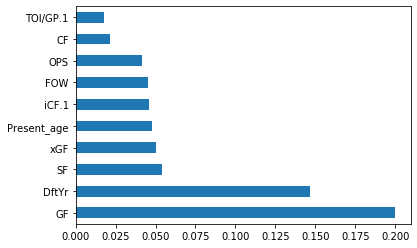

In [25]:
feat_importances = pd.Series(rf_exp.feature_importances_, index=new_train.columns)
feat_importances.nlargest(10).plot(kind='barh')

In [36]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', nrounds = 1000, 
    early_stopping_rounds = 50, max_depth = 8, eta = 0.3, nthread = 2)


In [37]:
xg_reg.fit(new_train,labels_train)

preds = xg_reg.predict(new_test)

[22:29:00] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [38]:
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(salary_test, preds))
print('Mean Squared Error:', metrics.mean_squared_error(salary_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(salary_test, preds)))

Mean Absolute Error: 952636.611879771
Mean Squared Error: 2464825450797.168
Root Mean Squared Error: 1569976.2580361424


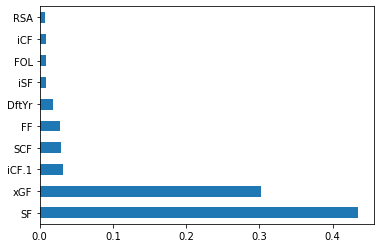

In [39]:
feat_importances = pd.Series(xg_reg.feature_importances_, index=new_train.columns)
feat_importances.nlargest(10).plot(kind='barh')